In [1]:
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
import sys
BASE_PATH = os.path.realpath('..')
DATASETS_DIR = os.path.join(BASE_PATH, 'datasets')
LIB_DIR = os.path.join(BASE_PATH,'lib')
if LIB_DIR not in sys.path:
    sys.path.append(LIB_DIR)

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from importlib import reload

In [2]:
import fca_interp as fcai

In [3]:
from importlib import reload

In [4]:
from sklearn.datasets import load_boston

# Attribute Information:

Input variables:

__bank client data:__
1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown')

__related with the last contact of the current campaign:__
8. contact: contact communication type (categorical: 'cellular','telephone')
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

__other attributes:__
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

__social and economic context attributes__
16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
17. cons.price.idx: consumer price index - monthly indicator (numeric)
18. cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19. euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr.employed: number of employees - quarterly indicator (numeric)

__Output variable (desired target):__
21. y - has the client subscribed a term deposit? (binary: 'yes','no')



In [5]:
bank_ds = pd.read_csv(os.path.join(DATASETS_DIR, 'bank.csv'), sep=';')

for f in ['default', 'housing','loan', 'y']:
    bank_ds[f] = bank_ds[f].apply(lambda x: {'no':0, 'yes':1, 'unknown':None}[x])
bank_ds.loc[bank_ds['pdays']==-1, 'pdays'] = None
real_feats = ['age', 'default', 'housing', 'loan', 'duration', 'campaign', 'pdays', 'previous', 'balance']
cat_feats  = ['job', 'marital', 'education', 'contact', 'month', 'day', 'poutcome',]

bank_ds.index = bank_ds.index.astype(str)
bank_ds[cat_feats] = bank_ds[cat_feats].astype(str)
bank_ds

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,0,1787,0,0,cellular,19,oct,79,1,NaN,0,unknown,0
1,33,services,married,secondary,0,4789,1,1,cellular,11,may,220,1,339.0,4,failure,0
2,35,management,single,tertiary,0,1350,1,0,cellular,16,apr,185,1,330.0,1,failure,0
3,30,management,married,tertiary,0,1476,1,1,unknown,3,jun,199,4,NaN,0,unknown,0
4,59,blue-collar,married,secondary,0,0,1,0,unknown,5,may,226,1,NaN,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,0,-333,1,0,cellular,30,jul,329,5,NaN,0,unknown,0
4517,57,self-employed,married,tertiary,1,-3313,1,1,unknown,9,may,153,1,NaN,0,unknown,0
4518,57,technician,married,secondary,0,295,0,0,cellular,19,aug,151,11,NaN,0,unknown,0
4519,28,blue-collar,married,secondary,0,1137,0,0,cellular,6,feb,129,4,211.0,3,other,0


In [29]:
import fca_interp as fcai

In [50]:
fcai = reload(fcai)

In [51]:
bank_ds

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,balance_round,duration_round,pdays_round
0,30,unemployed,married,primary,0,1787,0,0,cellular,19,oct,79,1,NaN,0,unknown,0,3162.277660,1.0,NaN
1,33,services,married,secondary,0,4789,1,1,cellular,11,may,220,1,339.0,4,failure,0,3162.277660,4.0,330.0
2,35,management,single,tertiary,0,1350,1,0,cellular,16,apr,185,1,330.0,1,failure,0,1000.000000,3.0,330.0
3,30,management,married,tertiary,0,1476,1,1,unknown,3,jun,199,4,NaN,0,unknown,0,1000.000000,3.0,NaN
4,59,blue-collar,married,secondary,0,0,1,0,unknown,5,may,226,1,NaN,0,unknown,0,-0.000000,4.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,0,-333,1,0,cellular,30,jul,329,5,NaN,0,unknown,0,-316.227766,5.0,NaN
4517,57,self-employed,married,tertiary,1,-3313,1,1,unknown,9,may,153,1,NaN,0,unknown,0,-3162.277660,3.0,NaN
4518,57,technician,married,secondary,0,295,0,0,cellular,19,aug,151,11,NaN,0,unknown,0,316.227766,3.0,NaN
4519,28,blue-collar,married,secondary,0,1137,0,0,cellular,6,feb,129,4,211.0,3,other,0,1000.000000,2.0,210.0


In [35]:
from scipy.stats import entropy

In [53]:
real_feats_round = [f+'_round' if f+'_round' in bank_ds else f for f in real_feats]
cat_feats_round = [f+'_round' if f+'_round' in bank_ds else f for f in cat_feats]

In [62]:
flg = bank_ds['y']==1
k = 15
flg.loc[flg] = [True]*k+[False]*(flg.sum()-k)

In [130]:
fcai = reload(fcai)

In [131]:
mvcntx_full = fcai.MultiValuedContext(bank_ds[cat_feats_round+real_feats_round], y_true=bank_ds['y'], cat_attrs=cat_feats_round)

In [132]:
mvcntx = fcai.MultiValuedContext(bank_ds[flg][cat_feats_round+real_feats_round], y_true=bank_ds[flg]['y'], cat_attrs=cat_feats_round)

In [133]:
fm_ps = fcai.FormalManager(mvcntx, cat_feats=cat_feats_round, task_type='binary classification')

In [244]:
fm_ps.construct_concepts()

/root/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [245]:
fm_ps.calc_strongness(mvcntx_full, use_tqdm=True)


 31%|███       | 7394/23675 [00:16<00:35, 464.89it/s]


 58%|█████▊    | 13714/23675 [00:32<00:23, 418.08it/s]


 86%|████████▋ | 20457/23675 [00:47<00:07, 421.57it/s]


100%|██████████| 23675/23675 [00:55<00:00, 427.02it/s]


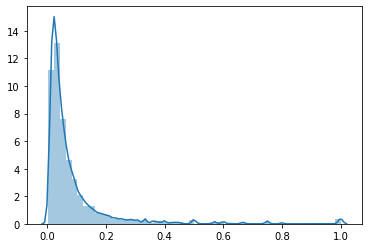

In [246]:
sns.distplot([c._metrics['strongness'] for c in fm_ps.get_concepts()])

In [247]:
fm_ps._concepts = [c for c in fm_ps._concepts if c._metrics['strongness']>0.2]

In [160]:
fm_ps.construct_lattice(use_tqdm=True)


100%|██████████| 437/437 [00:00<00:00, 506.89it/s]


In [162]:
fm_ps.calc_stability_approx(use_tqdm=True)


100%|██████████| 437/437 [00:00<00:00, 2329.30it/s]


In [166]:
fm_ps.get_concept_by_id(18772)

PatternStructure 18772
level: 1
extent (len: 4): 1, 6, 11, 14
intent (len: 10): 0 in ["admin.", "management", "retired", "services"], 2 = secondary, 3 in ["cellular", "telephone"], 4 in ["jul", "may"], 5 in ["14", "16", "18", "6"], 6 in ["failure", "unknown"], 7 in [27, 68], 11 in [7.0, 15.0], 12 in [1, 2], 14 in [0, 2]
new extent (len: 0): ∅
new_intent (len: 0): ∅
lower neighbours (len: 2): 23022, 21871
upper neighbours (len: 1): 18771
metric strongness = 0.5714285714285714
metric stab_min_bound = 0.0
metric stab_max_bound = 0.5
metric log_stab_min_bound = -0.0
metric log_stab_max_bound = 1.0
metric lstab_min_bound = -15.0

In [239]:
concepts = sorted([c  for c in fm_ps.get_concepts() if c._metrics['stab_min_bound'] is not None and c._metrics['stab_min_bound']>0 ], key=lambda c: c.get_id())

In [240]:
while True:
    for c in concepts:
        print(c)
        subconcepts = [c_ for c_ in concepts if c_!=c and c_.is_subconcept_of(c, trust_mode=True)]
        print(len(subconcepts))
        if len(subconcepts)>0:
            concepts = [c_ for c_ in concepts if c_ not in subconcepts]
            break
    else:
        break

PatternStructure 18337 level: 1 (3 objs, 10 attrs)
2
PatternStructure 18337 level: 1 (3 objs, 10 attrs)
0
PatternStructure 18348 level: 1 (3 objs, 10 attrs)
1
PatternStructure 18337 level: 1 (3 objs, 10 attrs)
0
PatternStructure 18348 level: 1 (3 objs, 10 attrs)
0
PatternStructure 19061 level: 0 (3 objs, 10 attrs)
2
PatternStructure 18337 level: 1 (3 objs, 10 attrs)
0
PatternStructure 18348 level: 1 (3 objs, 10 attrs)
0
PatternStructure 19061 level: 0 (3 objs, 10 attrs)
0
PatternStructure 19351 level: 1 (3 objs, 10 attrs)
2
PatternStructure 18337 level: 1 (3 objs, 10 attrs)
0
PatternStructure 18348 level: 1 (3 objs, 10 attrs)
0
PatternStructure 19061 level: 0 (3 objs, 10 attrs)
0
PatternStructure 19351 level: 1 (3 objs, 10 attrs)
0
PatternStructure 19557 level: 0 (3 objs, 10 attrs)
1
PatternStructure 18337 level: 1 (3 objs, 10 attrs)
0
PatternStructure 18348 level: 1 (3 objs, 10 attrs)
0
PatternStructure 19061 level: 0 (3 objs, 10 attrs)
0
PatternStructure 19351 level: 1 (3 objs, 10 at

PatternStructure 19557 level: 0 (3 objs, 10 attrs)
0
PatternStructure 20193 level: 0 (3 objs, 10 attrs)
0
PatternStructure 20264 level: 1 (3 objs, 10 attrs)
0
PatternStructure 20343 level: 0 (3 objs, 10 attrs)
0
PatternStructure 20345 level: 0 (3 objs, 10 attrs)
0
PatternStructure 20358 level: 0 (3 objs, 10 attrs)
0
PatternStructure 20569 level: 1 (3 objs, 10 attrs)
0
PatternStructure 20733 level: 0 (3 objs, 10 attrs)
0
PatternStructure 21372 level: 1 (3 objs, 11 attrs)
0
PatternStructure 21395 level: 1 (3 objs, 11 attrs)
0
PatternStructure 21452 level: 1 (3 objs, 11 attrs)
0
PatternStructure 21488 level: 0 (3 objs, 11 attrs)
0
PatternStructure 21489 level: 1 (3 objs, 11 attrs)
0
PatternStructure 21724 level: 1 (3 objs, 11 attrs)
0
PatternStructure 21732 level: 1 (3 objs, 11 attrs)
0
PatternStructure 21735 level: 1 (4 objs, 11 attrs)
0
PatternStructure 21746 level: 1 (3 objs, 11 attrs)
0
PatternStructure 21859 level: 1 (3 objs, 11 attrs)
0
PatternStructure 21867 level: 1 (3 objs, 11 at

PatternStructure 22851 level: 1 (3 objs, 12 attrs)
0
PatternStructure 22891 level: 1 (3 objs, 12 attrs)
0
PatternStructure 22895 level: 2 (3 objs, 12 attrs)
0
PatternStructure 22905 level: 2 (3 objs, 12 attrs)
0
PatternStructure 22915 level: 0 (4 objs, 12 attrs)
0
PatternStructure 22919 level: 1 (3 objs, 12 attrs)
0
PatternStructure 22922 level: 1 (3 objs, 12 attrs)
0
PatternStructure 23021 level: 1 (4 objs, 12 attrs)
0
PatternStructure 23022 level: 2 (3 objs, 12 attrs)
0
PatternStructure 23030 level: 0 (3 objs, 12 attrs)
0
PatternStructure 23033 level: 1 (3 objs, 12 attrs)
0
PatternStructure 23037 level: 1 (3 objs, 12 attrs)
0
PatternStructure 23041 level: 0 (3 objs, 12 attrs)
0
PatternStructure 23062 level: 1 (4 objs, 12 attrs)
0
PatternStructure 23064 level: 1 (3 objs, 12 attrs)
0
PatternStructure 23065 level: 2 (3 objs, 12 attrs)
0
PatternStructure 23083 level: 2 (3 objs, 12 attrs)
0
PatternStructure 23084 level: 2 (3 objs, 12 attrs)
0
PatternStructure 23120 level: 2 (3 objs, 12 at

In [243]:
concepts[0]

PatternStructure 18337
level: 1
extent (len: 3): 4, 8, 11
intent (len: 10): 0 in ["admin.", "blue-collar", "retired"], 1 = divorced, 2 in ["primary", "secondary"], 4 in ["jul", "jun", "oct"], 5 in ["16", "22", "5"], 6 = unknown, 7 in [27, 78], 12 in [1, 3], 14 = 0, 15 in [316.22776601683796, 1000.0]
new extent (len: 1): 4
new_intent (len: 0): ∅
lower neighbours (len: 1): 22927
upper neighbours (len: 1): 18336
metric strongness = 0.6
metric stab_min_bound = 0.5
metric stab_max_bound = 0.5
metric log_stab_min_bound = 1.0
metric log_stab_max_bound = 1.0
metric lstab_min_bound = -15.0

In [241]:
len(concepts)

139

In [173]:
max([len(c.get_extent()) for c in fm_ps.get_concepts() if c._metrics['stab_min_bound'] is None ]

2

In [161]:
fm_ps.get_plotly_fig()

AttributeError: 'numpy.int64' object has no attribute 'replace'

In [69]:
fm_ps.get_concepts()

{PatternStructure 23334
 
 extent (len: 4): 1, 3, 5, 12
 intent (len: 12): 0 in ["blue-collar", "retired", "services", "technician"], 1 in ["divorced", "married"], 2 in ["secondary", "tertiary"], 3 in ["cellular", "telephone"], 4 in ["aug", "jul", "nov"], 5 in ["13", "14", "7"], 6 in ["failure", "unknown"], 7 in [32, 68], 11 in [2.0, 15.0], 12 in [1, 3], 14 in [0, 2], 15 in [1000.0, 3162.2776601683795],
 PatternStructure 23335
 
 extent (len: 4): 1, 5, 9, 12
 intent (len: 12): 0 in ["blue-collar", "retired", "services", "technician"], 1 in ["divorced", "married"], 2 in ["secondary", "tertiary"], 3 in ["cellular", "telephone"], 4 in ["jul", "jun", "nov"], 5 in ["14", "15", "7"], 6 in ["failure", "other", "unknown"], 7 in [32, 68], 11 in [2.0, 15.0], 12 in [1, 2], 14 in [0, 2], 15 in [1000.0, 3162.2776601683795],
 PatternStructure 23337
 
 extent (len: 4): 1, 4, 5, 12
 intent (len: 12): 0 in ["blue-collar", "retired", "services"], 1 in ["divorced", "married"], 2 in ["primary", "secondary

In [21]:
from datetime import datetime